In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer, normalize, RobustScaler
from functools import partial
from pathlib import Path
from joblib import load, dump

from scipy import stats
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles, MolToSmiles

In [2]:
np.random.seed(5)

In [3]:
sns.set(rc={'figure.figsize': (16, 16)})
sns.set_style('whitegrid')
sns.set_context('paper',font_scale=1.5)

# Load Data

In [4]:
SAVE_DIR = Path('../models/LOGS/random_split/PropertyFP_reduced/aqsoldb')
SAVE_DIR.mkdir(exist_ok=True,parents=True)

In [5]:
data = pd.read_csv('../data/AqSOLDB/curated-solubility-dataset_processed.csv')
data.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT,processed_smiles
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000,210.377334,CCCCCCCCCCCCCCCCCC[N+](C)(C)C
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996,511.229248,O=C1Nc2cccc3cccc1c23
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782,202.661065,O=Cc1ccc(Cl)cc1
3,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427,769.899934,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...
4,A-10,vinyltoluene,"InChI=1S/C9H10/c1-3-9-6-4-5-8(2)7-9/h3-7H,1H2,2H3",JZHGRUMIRATHIU-UHFFFAOYSA-N,Cc1cccc(C=C)c1,-3.123150,0.0,1,G1,118.179,...,46.0,1.0,0.0,0.0,1.0,0.00,55.836626,3.070761,211.033225,C=Cc1cccc(C)c1


# Exploratory data analysis

In this notebook we'll cover three main topics:

   - **What's the relationship between our features and solubility?**
   - **What's the distribution of our target variable?**
   - **Are there outliers?**

Let's start by counting how many features we have. In total we have 17 descriptors already calculated for our data set.

In [6]:
descriptors = ['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT']

In [7]:
print(len(descriptors))

17


We can check the correlation between each feature and solubility using seaborn's regplot:

In [8]:
nr_rows = 6
nr_cols = 3
target = 'Solubility'

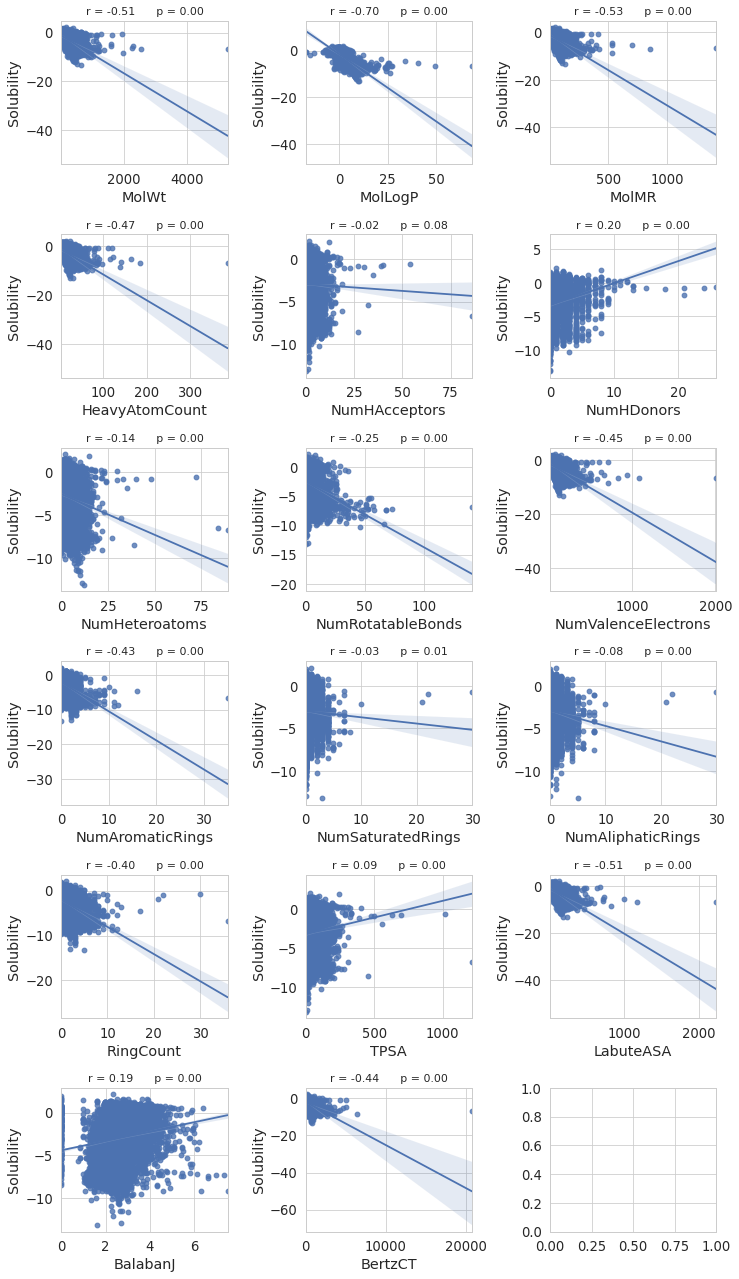

In [9]:
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):
            
            sns.regplot(x=data[descriptors[i]], y=data[target], ax = axs[r][c])
            
            stp = stats.pearsonr(data[descriptors[i]], data[target])

            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()  

Most have a negative correlation with solubility. In fact, the available features reflect more or less the size/complexity of the molecule (e.g. MolWt, RingCount, MolMR) and it's capacity to make inter and intramolecular interactions (e.g., NumValenceElectrons, NumHAcceptors, NumHDonors, MolLogP), which are known to influence their water solubility. For instance, a bigger molecules tend to be less soluble in water; the same applies for very liphophilic (aka aversion to water) molecules. On the other hand, more polar molecules, capable of making hydrogen bonds with water molecules are usually more soluble. 

Based on this preliminary analysis we can start thinking which features to include when training a regression model. 

## **Summary statistics**

In [10]:
data.describe()

,Solubility,SD,Ocurrences,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
count,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000,8842.000000
mean,-2.976133,0.059580,1.345397,253.005300,2.445421,66.159777,16.904207,3.174169,1.097263,4.667496,3.927279,92.041280,1.064917,0.318706,0.467541,1.532459,55.691938,103.250839,2.618086,443.741261
std,2.315261,0.205385,0.809062,150.964318,2.811272,41.035370,10.507310,2.693266,1.433689,3.480039,5.265856,56.843391,1.194696,0.910786,1.080055,1.528568,46.990709,62.039117,0.819560,436.470929
min,-13.171900,0.000000,1.000000,26.038000,-17.406400,3.450000,2.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.307062,-0.000004,0.000000
25%,-4.346725,0.000000,1.000000,163.176000,0.957900,42.360000,11.000000,2.000000,0.000000,2.000000,1.000000,60.000000,0.000000,0.000000,0.000000,0.000000,26.020000,67.199259,2.169297,183.391645
50%,-2.689542,0.000000,1.000000,226.446000,2.141950,59.451150,15.000000,3.000000,1.000000,4.000000,3.000000,82.000000,1.000000,0.000000,0.000000,1.000000,48.560000,92.834705,2.622906,368.308634
75%,-1.366225,0.000000,1.000000,310.365500,3.555000,81.085350,20.000000,4.000000,2.000000,6.000000,5.000000,110.000000,2.000000,0.000000,1.000000,2.000000,75.270000,126.296571,3.069899,606.196178
max,2.137682,3.270214,12.000000,5299.456000,68.541140,1419.351700,388.000000,86.000000,26.000000,89.000000,141.000000,2012.000000,35.000000,30.000000,30.000000,36.000000,1214.340000,2230.685124,7.517310,20720.267708


Let's take a look at the [```pairplot```](https://seaborn.pydata.org/generated/seaborn.pairplot.html) to see how the features interact with each other and with our target. 

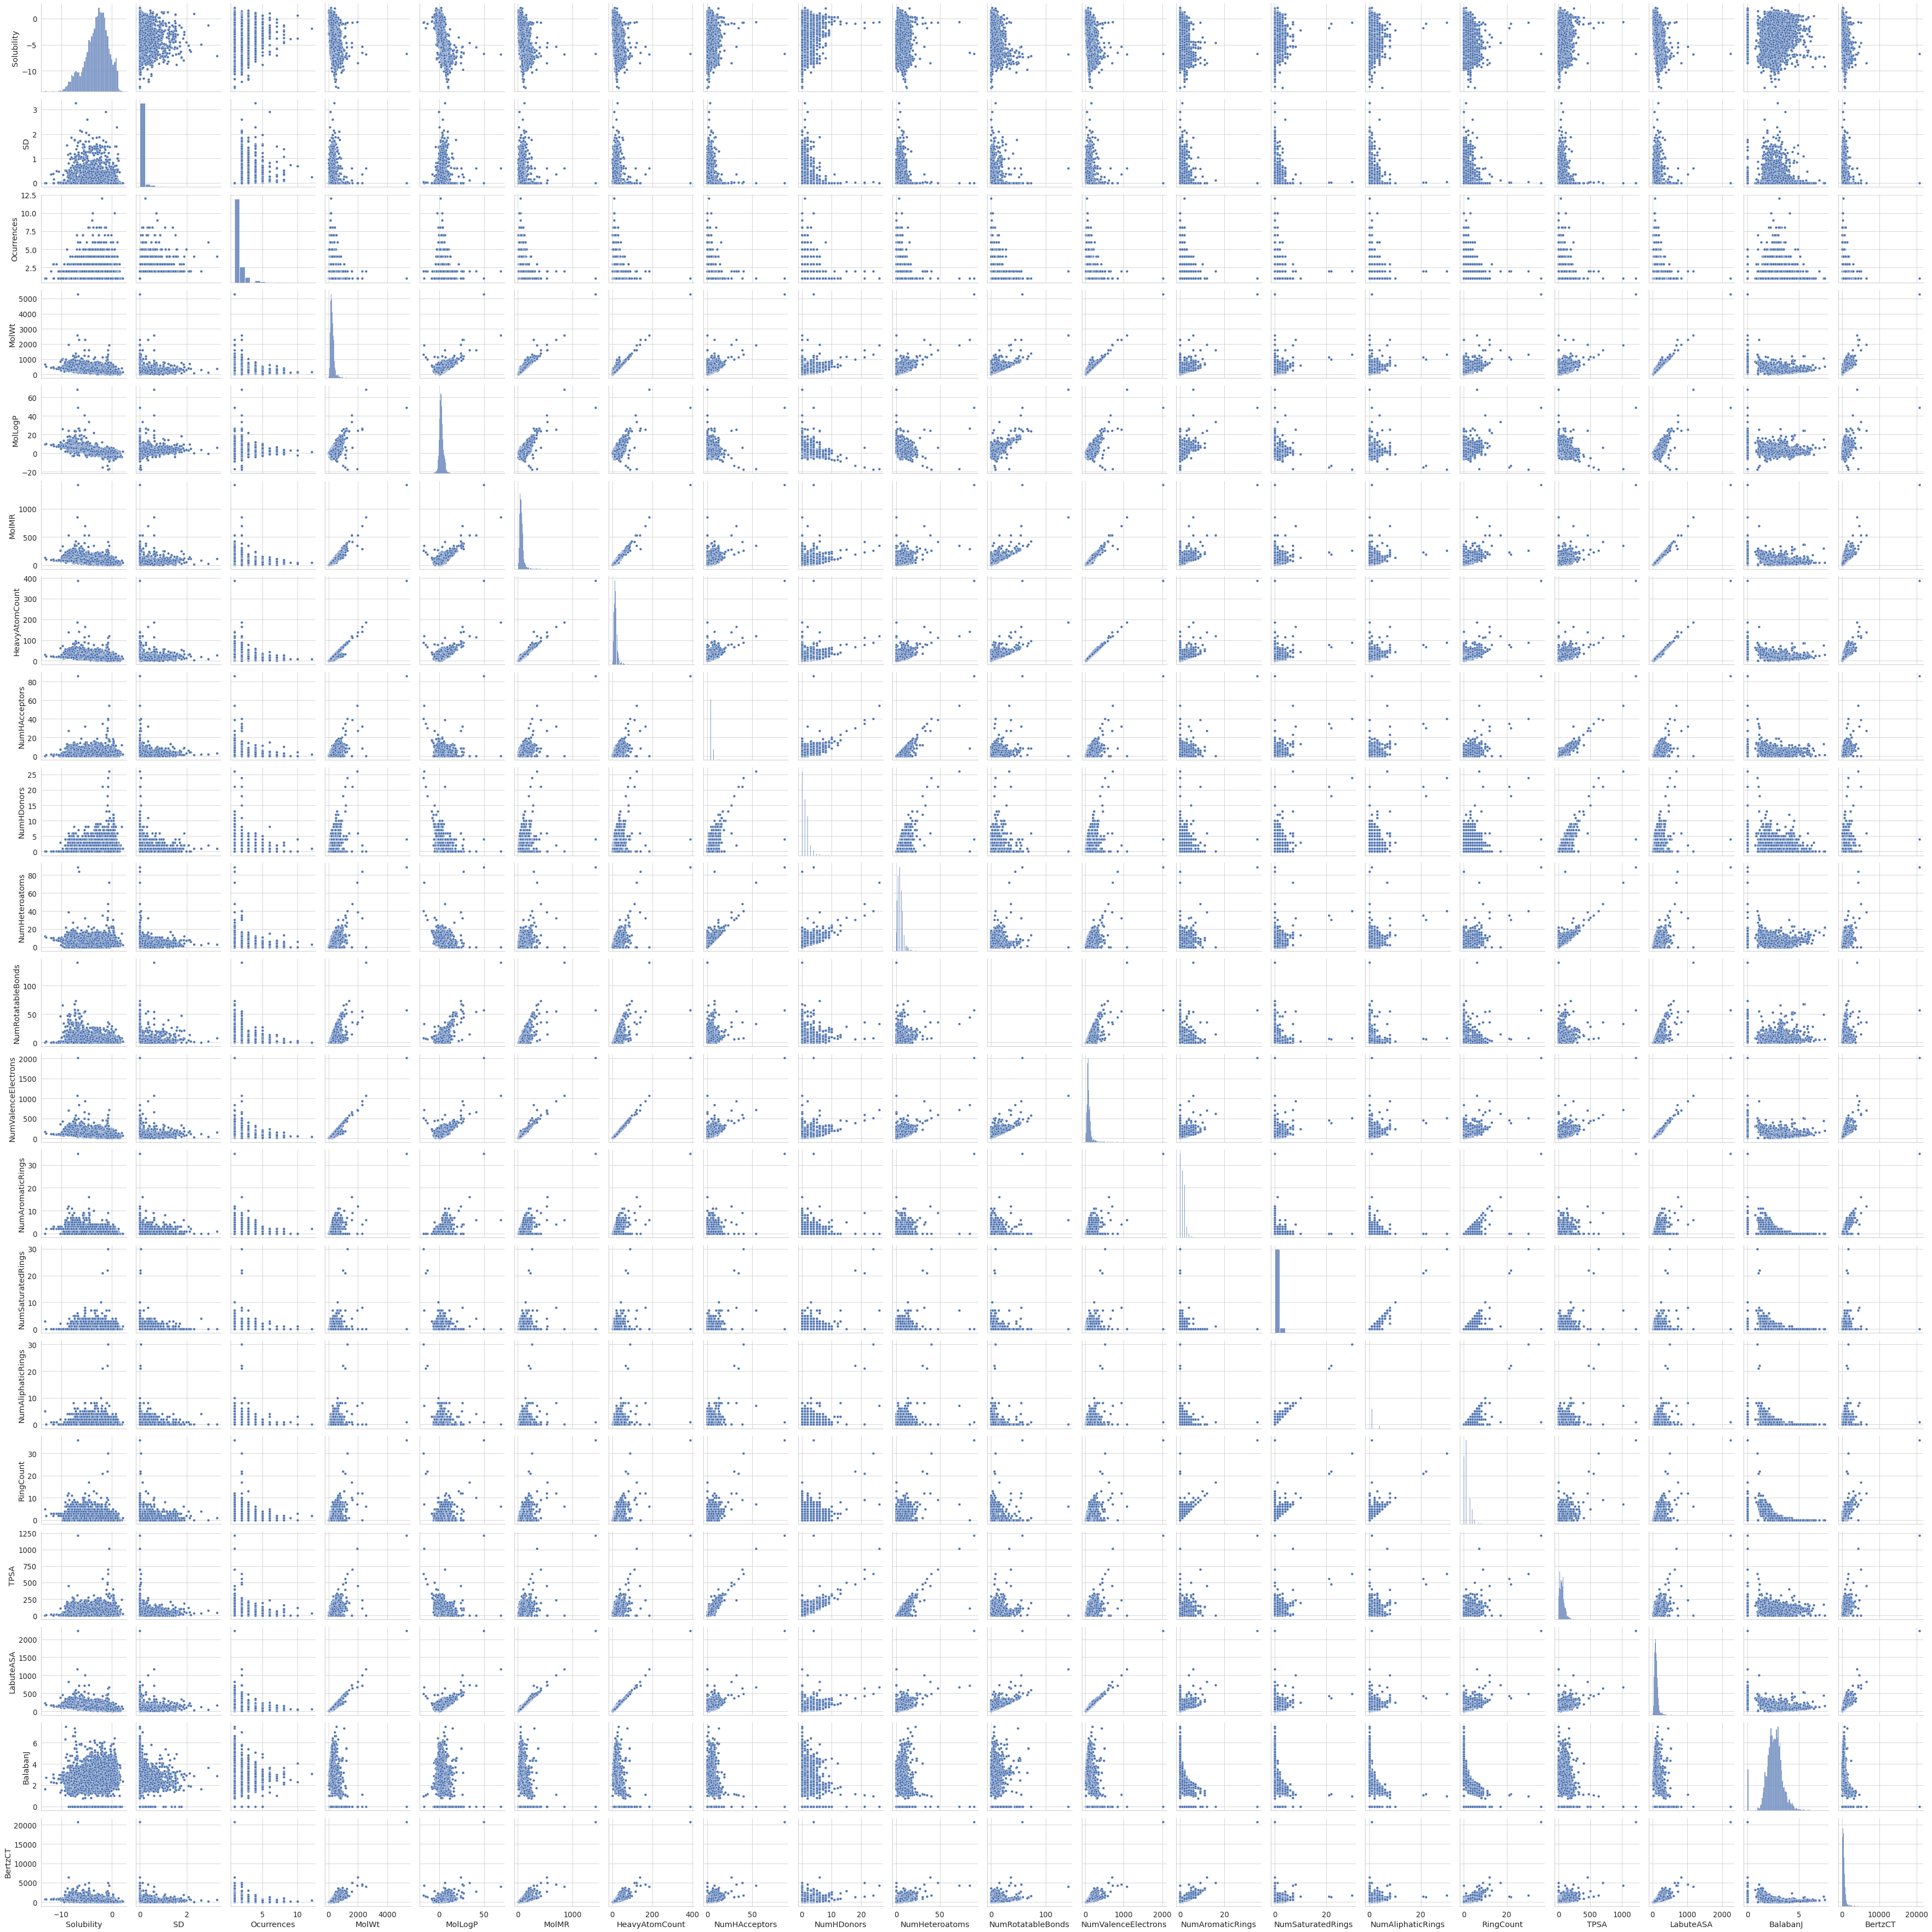

In [11]:
#collapse_output
sns.pairplot(data)

We can see some interesting information about this dataset. Our target have a normal-like distribution (first plot on the top left). This is very good because some algorithm we will use later assume that our data follows a normal distribution; being normal means it should be easier to train some models. 

### Normality check

Here's another view of the target solubility variable using violin and kernel density plots. The plots shows  a negative skew, with the distribution shifted to the right. This means there are more compounds with negative logS (i.e. lower solubility). Turns out the dataset distribution is not normal.

/home/marcossantana/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Solubility')

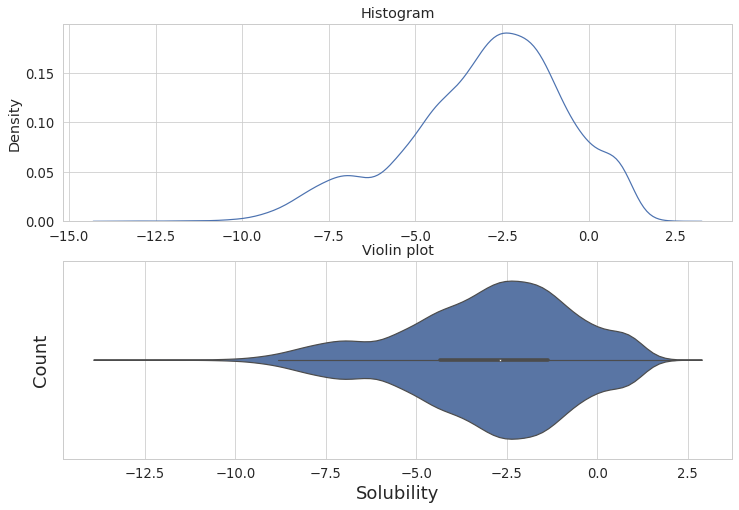

In [12]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(12,8))

sns.set_context(font_scale=2)
sns.kdeplot(data['Solubility'].values,ax=ax1)
sns.violinplot(data['Solubility'].values,ax=ax2)

ax1.title.set_text('Histogram')
ax2.title.set_text('Violin plot')

plt.ylabel('Count',fontsize=18)
plt.xlabel('Solubility',fontsize=18)

Our solubility values have a moderate to high left [**skewness**](https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html), with more negative values or less soluble molecules present. We can calculate skewness and kurtosis using scipy [```skew```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) and [```kurtosis```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html) functions, respectively. 

In [13]:

p,n = data[data['Solubility']>=0.0].shape[0], data[data['Solubility']<0.0].shape[0]

print(f'Number of positive logS  mols = {p}')
print(f'Number of negative logS mols = {n}')

Number of positive logS  mols = 777
Number of negative logS mols = 8065


Skewness and kurtosis can be defined as follows:

   - Skew is how much a distribution is pushed left or right, a measure of asymmetry in the distribution. We can think about skew as if someone was pushing the tail of a normal distribution.
   

   - Kurtosis quantifies how much of the distribution is in the tail. It is a simple and commonly used statistical test for normality. A good analogy is to think about punching the peak or top of the distribution and making it spread to the tails.
   

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Negative_and_positive_skew_diagrams_%28English%29.svg/446px-Negative_and_positive_skew_diagrams_%28English%29.svg.png" width="500"/>   

**Figure 1.** Skewness

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Standard_symmetric_pdfs.svg/1280px-Standard_symmetric_pdfs.svg.png" width="500"/>   

**Figure 2.** Kurtosis


In [14]:
from scipy.stats import skew, kurtosis, kurtosistest, skewtest
skew_val = skew(data['Solubility'])
kurtosis_val = kurtosis(data['Solubility'])
print(f'Skewness = {skew_val}')
print(f'Kurtosis = {kurtosis_val}')

Skewness = -0.5593279897021967
Kurtosis = 0.04726151580435545


We can confirm the deviation from a normal distribution by running different normality tests, [D'Agostino-Pearson ](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html), [Shapiro-Wilk](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html) and [Anderson](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html). 

In [15]:
from scipy.stats import normaltest, shapiro, anderson

The D'Agostino-Pearson normality test measures how far a distribution is from normality by computing skew and kurtosis. In this test, the null hypothesis (H0) is that our distribution is normal. We can use the k2 statistic and the p-value to reject or not H0.

In [16]:
print("D'Agostino K2")
k2, p = normaltest(data['Solubility'])
print(f'Statistics={k2}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

D'Agostino K2
Statistics=404.5266797956529, p=1.4392876240350922e-88
Sample does not look Gaussian (reject H0)


The Shapiro-Wilk normality test calculates a [W statistics](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) to check if a sample comes from a normal distribution. In this test, the null hypothesis (H0) is that our distribution is normal. We can use the W statistic and the p-value to reject or not H0.

In [17]:
print("Shapiro-Wilk")
w_stat, p = shapiro(data['Solubility'])
print(f'Statistics={w_stat}, p={p}')
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Shapiro-Wilk
Statistics=0.9754287600517273, p=2.2349054059092123e-36
Sample does not look Gaussian (reject H0)


/home/marcossantana/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The Anderson-Darling normality test measures if a sample comes from a specific distribution (e.g. normal). It measures the distance between the cumulative probability distribution between the sample and a specific distribution.  The test is a modified version of the nonparametric goodness-of-fit Kolmogorov-Smirnov test.
In this test, the null hypothesis (H0) is that our distribution is normal. We can use the [**A**](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm) statistic and the p-value to reject or not H0. In reality, the scipy function returns a range of critical values that allows us to interpret if H0 should be rejected. 

In [18]:
print("Anderson-Darling")
result  = anderson(data['Solubility'])
print(f'A statistic = {result.statistic}')
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print(f'{sl:.3f}: {cv:.3f}, data looks normal (fail to reject H0)')
	else:
		print(f'{sl:.3f}: {cv:.3f}, data does not look normal (reject H0)')

Anderson-Darling
A statistic = 54.56324161518205
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


We can also plot some features to investigate their distribution. 

Text(0.5, 1.0, 'BertzCT descriptor')

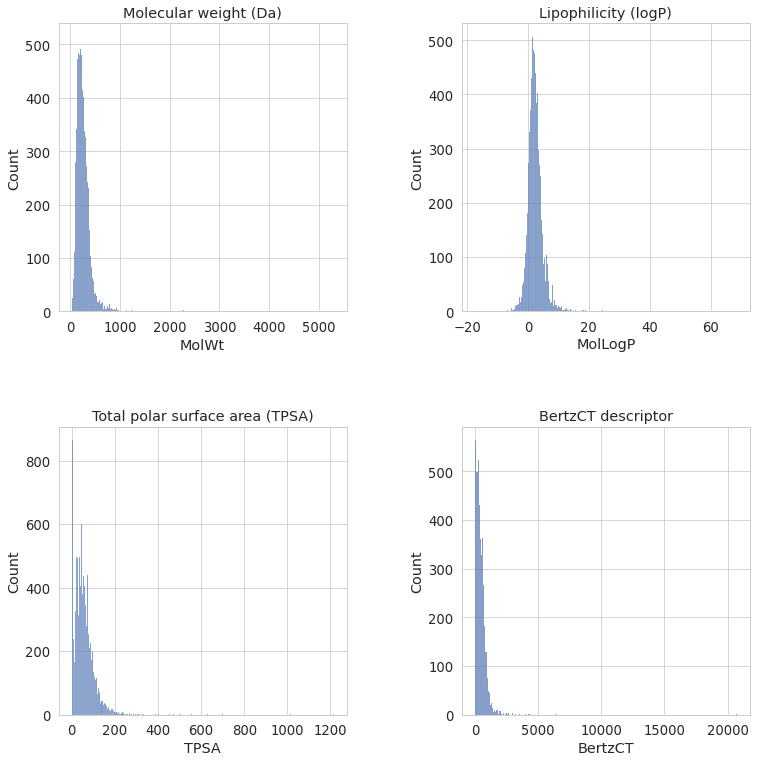

In [19]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))

sns.histplot(data['MolWt'],ax=ax1)
sns.histplot(data['MolLogP'],ax=ax2)
sns.histplot(data['TPSA'],ax=ax3)
sns.histplot(data['BertzCT'],ax=ax4)

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

ax1.set_title('Molecular weight (Da)')
ax2.set_title('Lipophilicity (logP)')
ax3.set_title('Total polar surface area (TPSA)')
ax4.set_title('BertzCT descriptor')

Molecular weight (MolWt), Lipophilicity (MolLogP), total polar surface area (TPSA) and the BertzCT topological descriptor show a clear positive skew. These distributions actually make sense based on our observations about solubility. Most of the molecules in the dataset have low solubilities, and as we can see from the above plots, there is a positive skew on molecular weight and lipophilicity.

The means of MolWt, MolLogP and TPSA also tells us that. On average, the dataset consists of moderatly lipophilic molecules with low polar surface areas:

In [20]:
mean_tpsa, mean_logp, mean_molwt = data['TPSA'].mean(),  data['MolWt'].mean(),  data['MolLogP'].mean()

In [21]:
print(f'Mean TPSA = {mean_tpsa}\nMean logP = {mean_logp}\nMean molecular weight = {mean_molwt}')

Mean TPSA = 55.691938475458294
Mean logP = 253.00529959285242
Mean molecular weight = 2.445421367337706


## Detecting outliers

We can use the information we have to identify data points that are very different from the general distribution and that could hinder the performance of a predictive model. These data points are called **outliers** and their presence is very bad for many type of algorithms, leading to longer training time, more complex models and maybe degraded performance. Let's use the previous descriptors, MolWt, MolLogP, TPSA and BertzCT as a guide. 

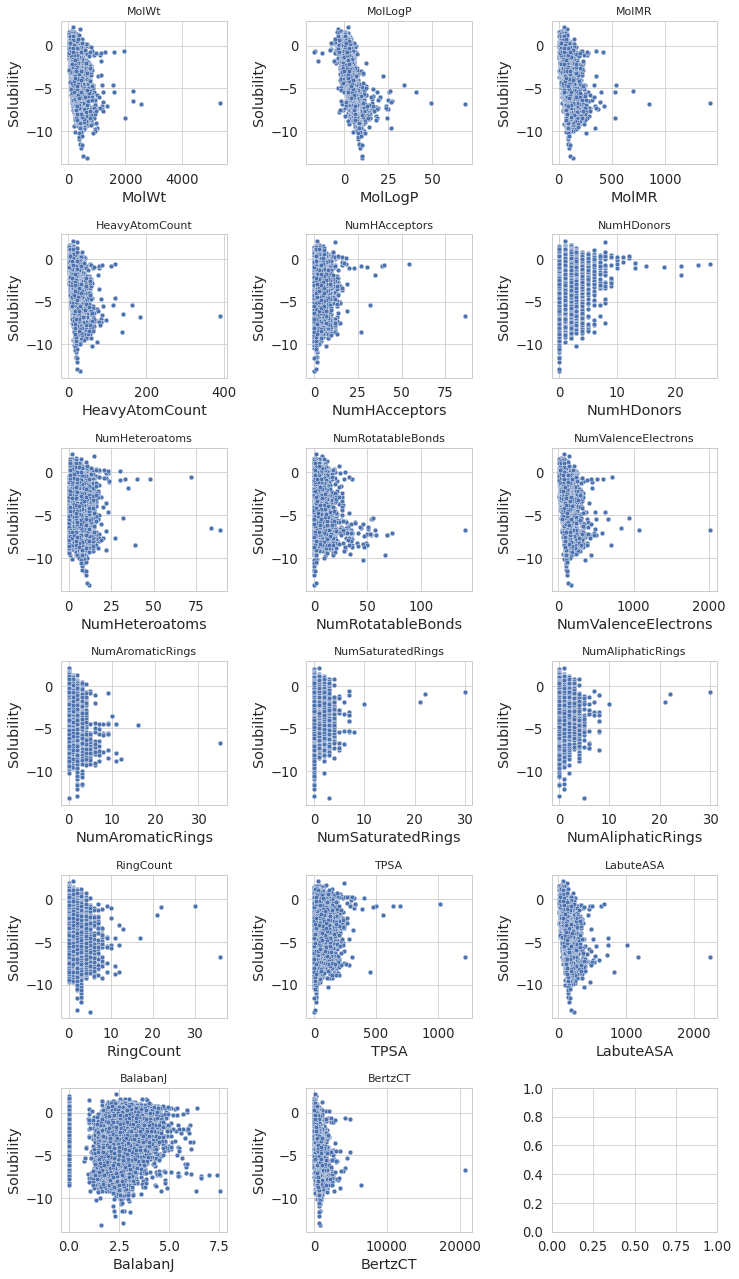

In [22]:
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(descriptors):
            sns.scatterplot(x=data[descriptors[i]], y=data[target], ax = axs[r][c])
            axs[r][c].set_title(descriptors[i],fontsize=11)
            
plt.tight_layout()    
plt.show()  

The scatter plots shows us that some points are distant from the others. An extreme case is a data point on the top right of the plots, showing high molecular weight, TPSA and logP! It does seem we have some outliers in our data. But how can we detect which molecules are outliers? Can we simply remove them based on some kind of rule of thumb? Let's investigate this!

### **Using mean and std to find outliers**

The first outlier detection method we'll use is based on the mean and standard deviation of our data. In this method, a point is considered outlier if it's 2 std below or above the mean of our sample.

In [23]:
c = 2
def get_outliers(data, feature_name, c=2):
    mean, std = data[feature_name].mean(),data[feature_name].std()
    bounds = mean - (c*std), mean + (c*std)
    outliers = data[~data[feature_name].between(*bounds)]
    non_outliers = data.iloc[data.index.difference(outliers.index)]
    return bounds, outliers, non_outliers

In [24]:
outliers = []

for i in descriptors:
    outliers.append(get_outliers(data, feature_name= i, c=2)[1])

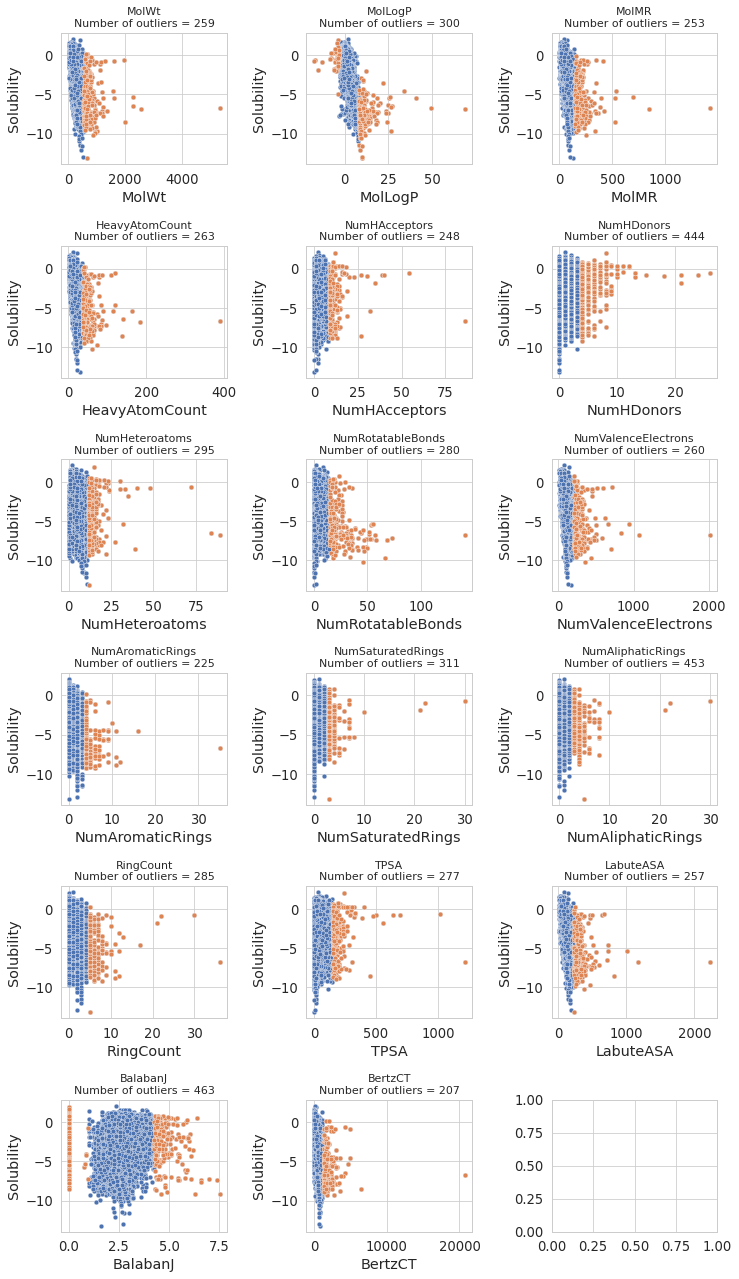

In [25]:

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(descriptors):
            sns.scatterplot(x=data[descriptors[i]], y=data[target], ax = axs[r][c])
            sns.scatterplot(x=outliers[i][descriptors[i]], y=outliers[i][target], ax = axs[r][c])
            
           # print(f'Possible number of outliers = {}')
            axs[r][c].set_title(f'{descriptors[i]}\nNumber of outliers = {len(outliers[i])}',fontsize=11)
            
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)            
plt.tight_layout()    
plt.show()  

In [26]:
print(f'Lower solubility bound = {bonds[0]}\nUpper solubility bound = {bonds[1]}')

NameError: name 'bonds' is not defined

The scatterplots shows some potential outliers for each feature. 

Let's take a closer look at solubility and one of the descriptor to get some insight of physicochemical properties of potential outliers. 

Water solubility has a strong negative correlation with lipophilicity (logP). Ideally, we should see a solubility decrease for more lipophilic molecules. Let's try using logP to identify potential outliers. 

In [ ]:
logp_bonds,logp_outliers,logp_non_outliers = get_outliers(data, feature_name= 'MolLogP', c=2)

We have some big molecules here...

In [ ]:
print(logp_bonds)

In [ ]:
print(f'Possible number of outliers = {len(logp_outliers)}')

We found 300 potential outliers that differ from the mean MolLogP by 2 std. We can clearly see the extreme point we identified earlier and some other more distant fromt he distribution. 

**Here's MolLogP before and after outliers**

In [ ]:
#collapse_output
fig, ax1 = plt.subplots(1,figsize=(20,16), sharey=True)
s=90
sns.scatterplot(x='MolLogP', y='Solubility', data =logp_non_outliers,ax=ax1,s=s,color='gray')
sns.scatterplot(x='MolLogP', y='Solubility', data =logp_outliers,ax=ax1,color='goldenrod',s=s)
ax1.set_title('MolLogP outliers',fontsize=18)
ax1.set_ylabel('Solubility',fontsize=18)
ax1.set_xlabel('MolLogP',fontsize=18)
#sns.scattrplot(x='MolLogP', y='Solubility', data = logp_non_outliers,ax=ax3,color='gray')
#ax3.set_title('Removed outliers')

If we remove the putative outliers we can get a better view of the relationship between logP and solubility.

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(36,12), sharey=True)
s=90

sns.scatterplot(x='MolLogP', y='Solubility', data =data,ax=ax1,s=s,color='gray')
ax1.set_title('Original data')

sns.scatterplot(x='MolLogP', y='Solubility', data =logp_non_outliers,ax=ax2,s=s,color='gray')
sns.scatterplot(x='MolLogP', y='Solubility', data =logp_outliers,ax=ax2,color='goldenrod',s=s)
ax2.set_title('Outliers')

sns.scatterplot(x='MolLogP', y='Solubility', data = logp_non_outliers,ax=ax3,color='gray')
ax3.set_title('Removed outliers')

That looks much better! The scatterplot on the right shows that as logP increases, the solubility tends to decrease, which is what we expect from drug-like compounds. In general, very big compounds are less soluble and have a hard time being optimized into lead compounds or drugs. But what kind of molecules did we remove?

In [ ]:
from rdkit.Chem import Draw

In [ ]:
Draw.MolsToGridImage(list(map(MolFromSmiles, logp_outliers.processed_smiles)),subImgSize=(900,900))

Some potential outliers doesn't look very friendly or something that would be in drug discovery libraries! Take a look at this guy:

In [ ]:
smi = logp_outliers.processed_smiles.tolist()[2]
mol = MolFromSmiles(smi)
print(f'Outlier SMILES - {smi}')
mol

We might be better off without this kind of "ugly chemistry". But let's keep these monsters for now and explore other methods to outlier detection.

### **Interquartile range**

We can also use the interquartile range (IQR) to detect outliers. Simply put, we'll use a boxplot to detect molecules with solubilities higher than the 75th quartile and lower than the 25th quartile. 

In [ ]:
def iqr_detection(data, feature_name, std_cut=1.5):
    
    
    df = data.copy()
    df.reset_index(drop=True,inplace=True)
    
    q3 = np.quantile(df[feature_name],.75)
    q1 = np.quantile(df[feature_name],.25)

    iqr = q3 - q1
    
    cutoff = std_cut * iqr
    lower, upper = q1 - cutoff, q3 + cutoff
    
    outliers = df[(df[feature_name] < lower) | (df[feature_name] > upper)]
    ok_points = df.iloc[df.index.difference(outliers.index)]

    return (lower, upper), outliers, ok_points

We will consider a data point as outlier if it lies at above or below the cutoff value of 1.5 * IQR 

In [ ]:
iqr_bounds, iqr_outliers, iqr_okpoints = iqr_detection(data, 'Solubility')

In [ ]:
print(iqr_bounds)

In [ ]:
iqr_outliers = []

for i in descriptors:
    iqr_outliers.append(iqr_detection(data, feature_name= i)[1])
    
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(descriptors):
            sns.scatterplot(x=data[descriptors[i]], y=data[target], ax = axs[r][c])
            sns.scatterplot(x=iqr_outliers[i][descriptors[i]], y=iqr_outliers[i][target], ax = axs[r][c])
            
           # print(f'Possible number of outliers = {}')
            axs[r][c].set_title(f'{descriptors[i]}\nNumber of outliers = {len(iqr_outliers[i])}',fontsize=11)
            
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)            
plt.tight_layout()    
plt.show()  

### **Automatic detection**

We can also automate the detection of outliers using the [local outlier factor algorithm](http://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf)

The local outlier factor (LOF) adopts a notion of oulier that depends on the local neighborhood of each data point. This allows the algorithm to find data points that are different from the global distribution and also different from their neighbors. LOF does this by assigning an outlier factor to each data point, which is the degree each point deviates from its neighbors. An outlier is expected to have a local densitiy that is different from it's k-neighbors. 

#### Normalize data

Let's try to find some outliers with the available descriptors. But first, let's normalize them!

In [ ]:
X = data[descriptors].values
Y = data['Solubility'].values

In [ ]:
Y.shape

In [ ]:
scaler = RobustScaler()
Xnorm = scaler.fit(X).transform(X)

In [ ]:
Xnorm.mean(),Xnorm.std()

#### LocalOutlierFactor

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
outlier_scores = LocalOutlierFactor(n_neighbors=50,novelty=False).fit_predict(Xnorm)

In [ ]:
#bool_scores = np.where(outlier_scores==1,True,False)

In [ ]:
lof_no_outliers = data.iloc[outlier_scores == 1]
lof_outliers = data.iloc[outlier_scores == -1]
lof_no_outliers.shape,loc_outliers.shape

In [ ]:
#collapse_output
Draw.MolsToGridImage(list(map(MolFromSmiles, lof_outliers.processed_smiles.tolist())),subImgSize=(600,600))

In [ ]:
#collapse_output
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*5,nr_rows*5))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(descriptors):
            sns.scatterplot(x=lof_no_outliers[descriptors[i]], y=lof_no_outliers[target], ax = axs[r][c],linewidth=1.5,edgecolors='k',color='orange',s=90)
            
           # sns.regplot(x=data[descriptors[i]], y=data[target], ax = axs[r][c],color='gray')
            
            stp_data = stats.pearsonr(data[descriptors[i]], data[target])
            stp_clean = stats.pearsonr(lof_no_outliers[descriptors[i]], lof_no_outliers[target])

            str_title = f'Old rp = {stp_data[0]:.3f} p = {stp_data[1]:.5f}\nNew rp = {stp_clean[0]:.3f} p = {stp_clean[1]:.5f}'
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()  

### Save the cleaned dataset

In [ ]:
lof_no_outliers.to_csv('../data/AqSOLDB/curated-solubility-dataset_clean.csv',index=False)

It seems LOF removed the most extreme points. After removing outliers, we can see that the correlation between each feature and solubility increased. The only exception was TPSA, which showed a small decrease in the Pearson's correlation.


In the next posts, we'll explore more of this data. The main question we'll try to answer is: can we train a model with good performance to predict water solubility?

# References

**Detecting outliers**

https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html

https://www.dummies.com/programming/big-data/data-science/graphical-tests-of-data-outliers/

https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf

https://towardsdatascience.com/local-outlier-factor-for-anomaly-detection-cc0c770d2ebe


**Normality tests**

Machine learning mastery post: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

Shapiro-Wilk test: https://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm

Anderson-Darling test : https://www.itl.nist.gov/div898/handbook/prc/section2/prc21.htm


GraphPad entry: https://www.graphpad.com/guides/prism/latest/statistics/stat_choosing_a_normality_test.htm